In [1]:
import numpy as np
import pandas as pd

import os

import pathlib
import datetime
from pv_model_function import *
from scipy.interpolate import CubicSpline
import pvlib

In [2]:
base_dir = os.path.join(pathlib.Path.home(), 'ecen5407', 'ecen5407_project2')
data_pt = os.path.join(base_dir, "data", "222628_32.73_-117.18_2012.csv")

lat, lon = 32.73, -117.18
offset = 8

In [3]:
nsrdb = pd.read_csv(data_pt, skiprows=2, usecols=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'DHI', 'GHI',
       'DNI', 'Surface Albedo', 'Wind Speed', 'Pressure'])
local_index = pd.DatetimeIndex(nsrdb['Year'].astype(str) + '-' + nsrdb['Month'].astype(str) +
                             '-' + nsrdb['Day'].astype(str) + ' ' + nsrdb['Hour'].astype(str) +
                               ':' + nsrdb['Minute'].astype(str))
nsrdb.set_index(local_index, inplace=True)

File needs to contain exactly one year of data - https://sam.nrel.gov/forum/forum-general/2964-sam-could-not-determine-time-step-in-weather-file.html

In [4]:
start_date = str(nsrdb.index[0])
end_date = '2012-12-31 23:55:00'

times_interp = pd.date_range(start_date, end_date, freq='5min')

nsrdb_interpolated = pd.DataFrame(index=times_interp)


times_float = times_interp.to_numpy().astype(float)
for i in ['Temperature', 'DHI', 'GHI',
       'DNI', 'Surface Albedo', 'Wind Speed', 'Pressure']:
    cs = CubicSpline(nsrdb.index.to_numpy().astype(float), nsrdb[i].values)
    nsrdb_interpolated[i] = cs(times_float)
    nsrdb_interpolated[i] = np.maximum(nsrdb_interpolated[i], 0)
nsrdb_interpolated['dni_extra'] = pvlib.irradiance.get_extra_radiation(nsrdb_interpolated.index)

These are the values that are used to infer time steps

In [5]:
nsrdb_interpolated['Year'] = nsrdb_interpolated.index.year
nsrdb_interpolated['Month'] = nsrdb_interpolated.index.month
nsrdb_interpolated['Day'] = nsrdb_interpolated.index.day
nsrdb_interpolated['Hour'] = nsrdb_interpolated.index.hour
nsrdb_interpolated['Minute'] = nsrdb_interpolated.index.minute

In [6]:
len(nsrdb_interpolated)

105408

Check for any irregular timesteps

In [20]:
np.unique((nsrdb_interpolated.index.shift(periods=1, freq='1h') - nsrdb_interpolated.index))

array([3600000000000], dtype='timedelta64[ns]')

In [25]:
save_pt = os.path.join(base_dir, "data", "222628_32.73_-117.18_2012_interpolated.csv")
nsrdb_interpolated.to_csv(save_pt)

Used to check output of PySam simulation

In [5]:
loc = pvlib.location.Location(lat,lon, altitude=0)
fake_index = pd.date_range(datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=-offset),
                           datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=offset), freq='5min')
solar_position = loc.get_solarposition(times=fake_index)
solar_position.set_index(solar_position.index.shift(periods=-offset, freq = '1h'), inplace = True)
solar_position = solar_position.loc[times_interp]

In [6]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2012-01-01 00:00:00,170.146547,170.146547,-80.146547,-80.146547,10.879837,-3.230326
2012-01-01 00:05:00,169.889609,169.889609,-79.889609,-79.889609,17.349760,-3.231973
2012-01-01 00:10:00,169.522520,169.522520,-79.522520,-79.522520,23.451605,-3.233620
2012-01-01 00:15:00,169.056396,169.056396,-79.056396,-79.056396,29.111275,-3.235267
2012-01-01 00:20:00,168.503319,168.503319,-78.503319,-78.503319,34.295685,-3.236914
...,...,...,...,...,...,...
2012-12-31 23:35:00,169.526865,169.526865,-79.526865,-79.526865,337.542678,-3.578811
2012-12-31 23:40:00,169.875962,169.875962,-79.875962,-79.875962,343.677797,-3.580440
2012-12-31 23:45:00,170.113891,170.113891,-80.113891,-80.113891,350.160055,-3.582070
2012-12-31 23:50:00,170.232499,170.232499,-80.232499,-80.232499,356.868522,-3.583699


In [6]:
# nsrdb_utc = nsrdb_interpolated.set_index(
#     nsrdb_interpolated.index.shift(periods=offset, freq = '1h'))

# nsrdb_utc['Year'] = nsrdb_utc.index.year
# nsrdb_utc['Month'] = nsrdb_utc.index.month
# nsrdb_utc['Day'] = nsrdb_utc.index.day
# nsrdb_utc['Hour'] = nsrdb_utc.index.hour
# nsrdb_utc['Minute'] = nsrdb_utc.index.minute

# nsrdb_utc.set_index(pd.RangeIndex(start=1, stop=len(nsrdb_utc) + 1), inplace=True)
# save_pt = os.path.join(base_dir, "data", "222628_32.73_-117.18_2012_interpolated.csv")
# nsrdb_utc.to_csv(save_pt)

In [7]:
base_dir = os.path.join(pathlib.Path.home(), 'ecen5407', 'ecen5407_project2')
data_pt = os.path.join(base_dir, "data", "Project 2 - Load Profile.csv")

load = pd.read_csv(data_pt)

For the complete dataset:
     Peak system load is 106.11 MW
     System baseload is 28.71 MW
When neither PV nor wind resources are available:
     Peak system load is 93.49 MW
     System baseload is 28.71 MW


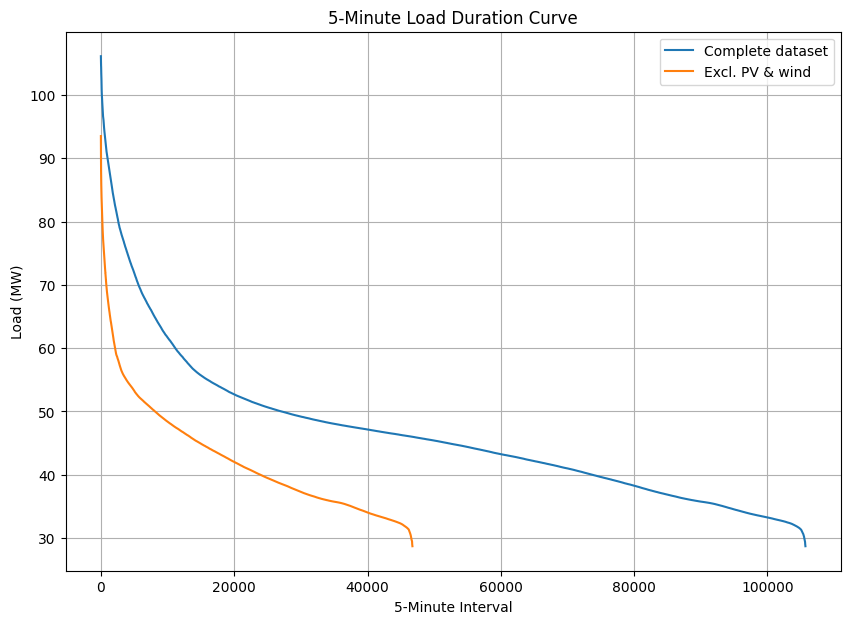

The maximum load on the system is: 106.11 MW, which occurs at 2012-07-27 15:15:00.


/home/emco4286/ecen5407/ecen5407_project2/load_inspection.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load_exceed_df.loc[:,'consecutive_id'] = (load_exceed_df['Datetime'].diff() > pd.Timedelta(minutes=5)).cumsum()
/home/emco4286/ecen5407/ecen5407_project2/load_inspection.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load_exceed_df.loc[:,'consecutive_id'] = (load_exceed_df['Datetime'].diff() > pd.Timedelta(minutes=5)).cumsum()
/home/emco4286/ecen5407/ecen5407_project2/load_inspection.py:56: S

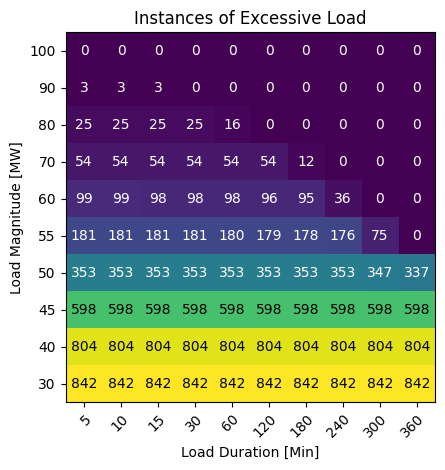

In [8]:
import load_inspection;

In [9]:
load['Datetime'] = load['Datetime'].apply(load_inspection.parse_leapday_datetimes)

# Change to 2012 so that the datetime library properly handles the leap day
load['Datetime'] = load['Datetime'].str.replace('2022', '2012')
# # Fix the extra day entries – they should just be Jan 1 of the following year
load['Datetime'] = load['Datetime'].str.replace('2021', '2013')
# # Convert all strings to datetime 
# load['Datetime'] = load['Datetime'].apply(load_inspection.parse_datestring)

In [10]:
my_index = pd.DatetimeIndex(load['Datetime'])

In [11]:
load.set_index(my_index, inplace=True)

In [15]:
load = load[:"2012-12-31 23:55:00"]

In [24]:
load["Load (MW)"] = load["Load (MW)"]/106

/tmp/ipykernel_322055/216473011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load["Load (MW)"] = load["Load (MW)"]/106


In [25]:
save_pt = os.path.join(base_dir, "data", "Project 2 - Load Profile_modified_index2.csv")
load.to_csv(save_pt)